lambdaq: [[ 9.41283806  0.32956196  5.85777548 18.65193611]]
Iterations:  308
Evidence Lower Bound:  [-33.35002712 -33.65890161 -32.13813818 -31.06937812 -30.30617284
 -30.57608296 -29.92307171 -29.61746331 -29.49210655 -29.41409462
 -29.55291905 -29.90531719 -29.56882937 -29.69466136 -29.85503331
 -29.74291401 -29.72380942 -29.65321033 -29.18309463 -29.09395568
 -29.34275347 -29.22817746 -28.52590386 -28.76009024 -28.74389909
 -28.66998022 -28.75787134 -28.67243981 -28.72697288]


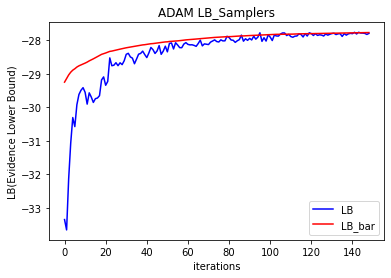

In [1]:
#Algorithm4 Gradient Ascent(ADAM) with control variate, CODE Reference from VBayesLab
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.special import psi
import math

y = [11, 12, 8, 10, 9, 8, 9, 10, 13, 7] # data
n = len(y)
#===========================
d = 4
S = 300  #number of Monte Carlo samples
beta1_adap_weight = 0.9 # adaptive learning weight
beta2_adap_weight = 0.9 # adaptive learning weight
eps0 = 0.1
w_adadelta = 0.95 # adaptive learning weight
eps_adadelta = 1e-7 # adaptive learning eps
   
max_iter = 2000
patience_max = 20
tau_threshold = max_iter/2
t_w = 50
#hyperparameter
alpha_hp = 1
beta_hp = 1
mu_hp = 0
sigma2_hp = 10

lambdaq = np.array([np.mean(y),1.5,2,3]).reshape(1,4)# initial lambdaq
lambda_best = lambdaq


#function h_lambda_fun
def h_lambda_fun(y,mu,sigma2,alpha_hp,beta_hp,mu_hp,sigma2_hp,mu_mu,sigma2_mu,alpha_sigma2,beta_sigma2):
    log_p_mu = -1/2*np.log(2*np.pi)-1/2*np.log(sigma2_hp)-(mu-mu_hp)**2/2/sigma2_hp
    log_p_sigma2 = alpha_hp*np.log(beta_hp)-np.log(math.gamma(alpha_hp))-(alpha_hp+1)*np.log(sigma2)-beta_hp/sigma2
    log_q_mu = -1/2*np.log(2*np.pi)-1/2*np.log(sigma2_mu)-(mu-mu_mu)**2/2/sigma2_mu
    log_q_sigma2 = alpha_sigma2*np.log(beta_sigma2)-np.log(math.gamma(alpha_sigma2))-(alpha_sigma2+1)*np.log(sigma2)-beta_sigma2/sigma2;
    llh = -n/2*np.log(2*np.pi)-n/2*np.log(sigma2)-1/2/sigma2*sum((y-mu)**2)
    return log_p_mu+log_p_sigma2+llh-log_q_mu-log_q_sigma2

mu_mu = lambdaq[0,0]
sigma2_mu = lambdaq[0,1]
alpha_sigma2 = lambdaq[0,2]
beta_sigma2 = lambdaq[0,3]
h_lambda = np.zeros((S,1))#  function h_lambda
grad_log_q_lambda = np.zeros((S,d))
grad_log_q_times_h = np.zeros((S,d))
for s in range(S):
    mu = np.random.normal(mu_mu,math.sqrt(sigma2_mu),1)
    sigma2 = 1./np.random.gamma(alpha_sigma2,1/beta_sigma2,1)

    grad_log_q_lambda[s,:]=np.array([(mu-mu_mu)/sigma2_mu,
                                     -1/2/sigma2_mu+(mu-mu_mu)**2/2/sigma2_mu**2,
                                     np.log(beta_sigma2)-psi(alpha_sigma2)-np.log(sigma2),
                                     alpha_sigma2/beta_sigma2-1/sigma2]).reshape(1,4)
    h_lambda[s] = h_lambda_fun(y,mu,sigma2,alpha_hp,beta_hp,mu_hp,sigma2_hp,mu_mu,sigma2_mu,alpha_sigma2,beta_sigma2)    
    grad_log_q_times_h[s,:] = grad_log_q_lambda[s,:]*h_lambda[s]

cv = np.zeros((1,d))# control variate
for i in range(d):
    aa = np.cov(grad_log_q_times_h[:,i],grad_log_q_lambda[:,i])
    cv[0,i] = aa[0,1]/aa[1,1]

grad_LB1= np.mean(grad_log_q_times_h[:,0])
grad_LB2= np.mean(grad_log_q_times_h[:,1])
grad_LB3= np.mean(grad_log_q_times_h[:,2])
grad_LB4= np.mean(grad_log_q_times_h[:,3])
grad_LB =np.array([grad_LB1,grad_LB2,grad_LB3,grad_LB4]).reshape(1,4)

#ADAM
g_adaptive = grad_LB
v_adaptive = g_adaptive**2
g_bar_adaptive = g_adaptive
v_bar_adaptive = v_adaptive

iter_ = 1
stop = False
LB = np.array([-1e3 for i in range(2000)])
LB_bar = np.array([-1e3 for i in range(2000)])
patience = 0  

while not stop:
    mu_mu = lambdaq[0,0]
    sigma2_mu = lambdaq[0,1]
    alpha_sigma2 = lambdaq[0,2]
    beta_sigma2 = lambdaq[0,3]
    h_lambda = np.zeros((S,1))# function h_lambda
    grad_log_q_lambda = np.zeros((S,d))
    grad_log_q_times_h = np.zeros((S,d))
    grad_log_q_times_h_cv = np.zeros((S,d))
    for s in range(S):
        mu = np.random.normal(mu_mu,math.sqrt(sigma2_mu),1)
        sigma2 = 1./np.random.gamma(alpha_sigma2,1/beta_sigma2,1)

        grad_log_q_lambda[s,:]=np.array([(mu-mu_mu)/sigma2_mu,
                                     -1/2/sigma2_mu+(mu-mu_mu)**2/2/sigma2_mu**2,
                                     np.log(beta_sigma2)-psi(alpha_sigma2)-np.log(sigma2),
                                     alpha_sigma2/beta_sigma2-1/sigma2]).reshape(1,4)
        h_lambda[s] = h_lambda_fun(y,mu,sigma2,alpha_hp,beta_hp,mu_hp,sigma2_hp,mu_mu,sigma2_mu,alpha_sigma2,beta_sigma2)    
        grad_log_q_times_h[s,:] = grad_log_q_lambda[s,:]*h_lambda[s]
        grad_log_q_times_h_cv[s,:] = grad_log_q_lambda[s,:]*(h_lambda[s]-cv)

    cv = np.zeros((1,d))# control variate
    for i in range(d):
        aa = np.cov(grad_log_q_times_h[:,i],grad_log_q_lambda[:,i])
        cv[0,i] = aa[0,1]/aa[1,1]
    #print("CV-control variate: " ,cv)
    grad_LB1= np.mean(grad_log_q_times_h_cv[:,0])
    grad_LB2= np.mean(grad_log_q_times_h_cv[:,1])
    grad_LB3= np.mean(grad_log_q_times_h_cv[:,2])
    grad_LB4= np.mean(grad_log_q_times_h_cv[:,3])
    grad_LB =np.array([grad_LB1,grad_LB2,grad_LB3,grad_LB4]).reshape(1,4)

    #case 'ADAM'
    g_adaptive = grad_LB
    v_adaptive = g_adaptive**2
    g_bar_adaptive = beta1_adap_weight*g_bar_adaptive+(1-beta1_adap_weight)*g_adaptive
    v_bar_adaptive = beta2_adap_weight*v_bar_adaptive+(1-beta2_adap_weight)*v_adaptive

    if iter_>=tau_threshold:
        stepsize = eps0*tau_threshold/iter_
    else:
        stepsize = eps0

    lambdaq = lambdaq+stepsize*g_bar_adaptive/np.sqrt(v_bar_adaptive)

    LB[iter_] = np.mean(h_lambda)

    if iter_>=t_w:
        LB_bar[iter_-t_w+1] = np.mean(LB[iter_-t_w+1:iter_])
        LB_bar[iter_-t_w+1]


    if iter_>t_w:
        if LB_bar[iter_-t_w+1]>=max(LB_bar):
            lambda_best = lambdaq
            patience = 0
        else:
            patience = patience+1

    if patience>patience_max or iter_>max_iter:
        stop = True
    iter_ = iter_+1

lambdaq = lambda_best
mu_mu = lambdaq[0,0]
sigma2_mu = lambdaq[0,1]
alpha_sigma2 = lambdaq[0,2]
beta_sigma2 = lambdaq[0,3]  
print("lambdaq:",lambdaq)
print("Iterations: ",iter_)
print("Evidence Lower Bound: ",LB[1:30])
plt.plot(LB[1:150], color="b",label="LB")
plt.plot(LB_bar[1:150], color="r",label="LB_bar")
plt.title("ADAM LB_Samplers") 
plt.xlabel("iterations"); plt.ylabel('LB(Evidence Lower Bound)')
plt.legend()
plt.show()